# Code to generate main manuscript figures

#### Note: Running this notebook requires downloading the output dict of all analyses, which can be found in the OSF repository. Alternatively, generate it  via `analysis.py` (see README).
- All constants are defined in ``analysis/config.py``, e.g. uncomment MODELS_EPOCHS_DICT in ``analysis/config.py`` for the models you want to analyze.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Import custom modules
from  all_tnn.analysis.config import Config
from all_tnn.analysis.util.convert_dict2h5 import read_h52dict
from all_tnn.analysis.visualization.acc_maps_visualization import plot_bar_plot_from_df
from all_tnn.analysis.visualization.acc_spatial_loss import generate_analysis_df
from all_tnn.analysis.visualization.energy_efficiency import plot_energy_consumption_across_epochs_lineplot, plot_stacked_energy_map_energy_vs_eccentricity, plot_stacked_energy_maps_normalized
from all_tnn.analysis.visualization.layer_visualization import visualize_layer
from all_tnn.analysis.visualization.smoothness_entropy_visualization import calculate_radial_entropy, plot_radial_entropy, plot_cluster_size, cluster_size_vs_eccentricity
from all_tnn.analysis.glm_analysis import run_full_GLM_analysis

# Set plotting style
import scienceplots  
plt.style.use(['science', 'nature', "ieee", 'no-latex'])
from all_tnn.analysis.visualization.colors import DECREASING_6COLORS, COLOR_THEME_WITH_ALPHA_SWEEP
color_palette = COLOR_THEME_WITH_ALPHA_SWEEP[1:] 

2025-02-13 13:30:59.978329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 13:31:01.925947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Setting Paths to where the data is stored
source_dir = '/share/klab/datasets/TNN_paper_save_dir/All-TNN_share/'
neural_level_src_dir = os.path.join(source_dir, 'neural_level_src')
behaviour_src_dir = os.path.join(source_dir, 'behaviour_src')
neural_level_h5_file_dir =  os.path.join(neural_level_src_dir, 'h5/')
config = Config(base_path = '/share/klab/datasets/',   analysis_dir = source_dir)

# List of additional directories to create
directories = [
    os.path.join(source_dir, 'plots', 'figure1'),   
    os.path.join(source_dir, 'plots', 'figure2'),        
    os.path.join(source_dir, 'plots', 'figure3'),        
    os.path.join(source_dir, 'plots', 'figure4'), 
    os.path.join(source_dir, 'plots', 'figure5'), 
]

# Iterate over the list and create each directory
for directory in directories:
    os.makedirs(directory, exist_ok=True)
    # Convert to absolute path for better readability
    absolute_path = os.path.abspath(directory)
    print(f"Created directory: {absolute_path}")

plot_path_fig1, plot_path_fig2, plot_path_fig3, plot_path_fig4, plot_path_fig5 = directories

Created directory: /share/klab/datasets/TNN_paper_save_dir/All-TNN_share/plots/figure1
Created directory: /share/klab/datasets/TNN_paper_save_dir/All-TNN_share/plots/figure2
Created directory: /share/klab/datasets/TNN_paper_save_dir/All-TNN_share/plots/figure3
Created directory: /share/klab/datasets/TNN_paper_save_dir/All-TNN_share/plots/figure4
Created directory: /share/klab/datasets/TNN_paper_save_dir/All-TNN_share/plots/figure5


## Figure 1 
### Categorization performance 
Classification accuracy of all All-TNNs and control models on the ecoset test set. 
Running these cells will plot the figures and save them to `save_dir`

/share/klab/vkapoor/python_workspace/All-TNN/all_tnn/analysis/visualization/acc_maps_visualization.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(palette=COLOR_THEME_WITH_ALPHA_SWEEP[color3_start_id:], *args, **kwargs)
/share/klab/vkapoor/python_workspace/All-TNN/all_tnn/analysis/visualization/acc_maps_visualization.py:64: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.barplot(palette=COLOR_THEME_WITH_ALPHA_SWEEP[color3_start_id:], *args, **kwargs)


Saved plot to /share/klab/datasets/TNN_paper_save_dir/All-TNN_share/plots/figure1accuracy_compare_across_alphas.pdf


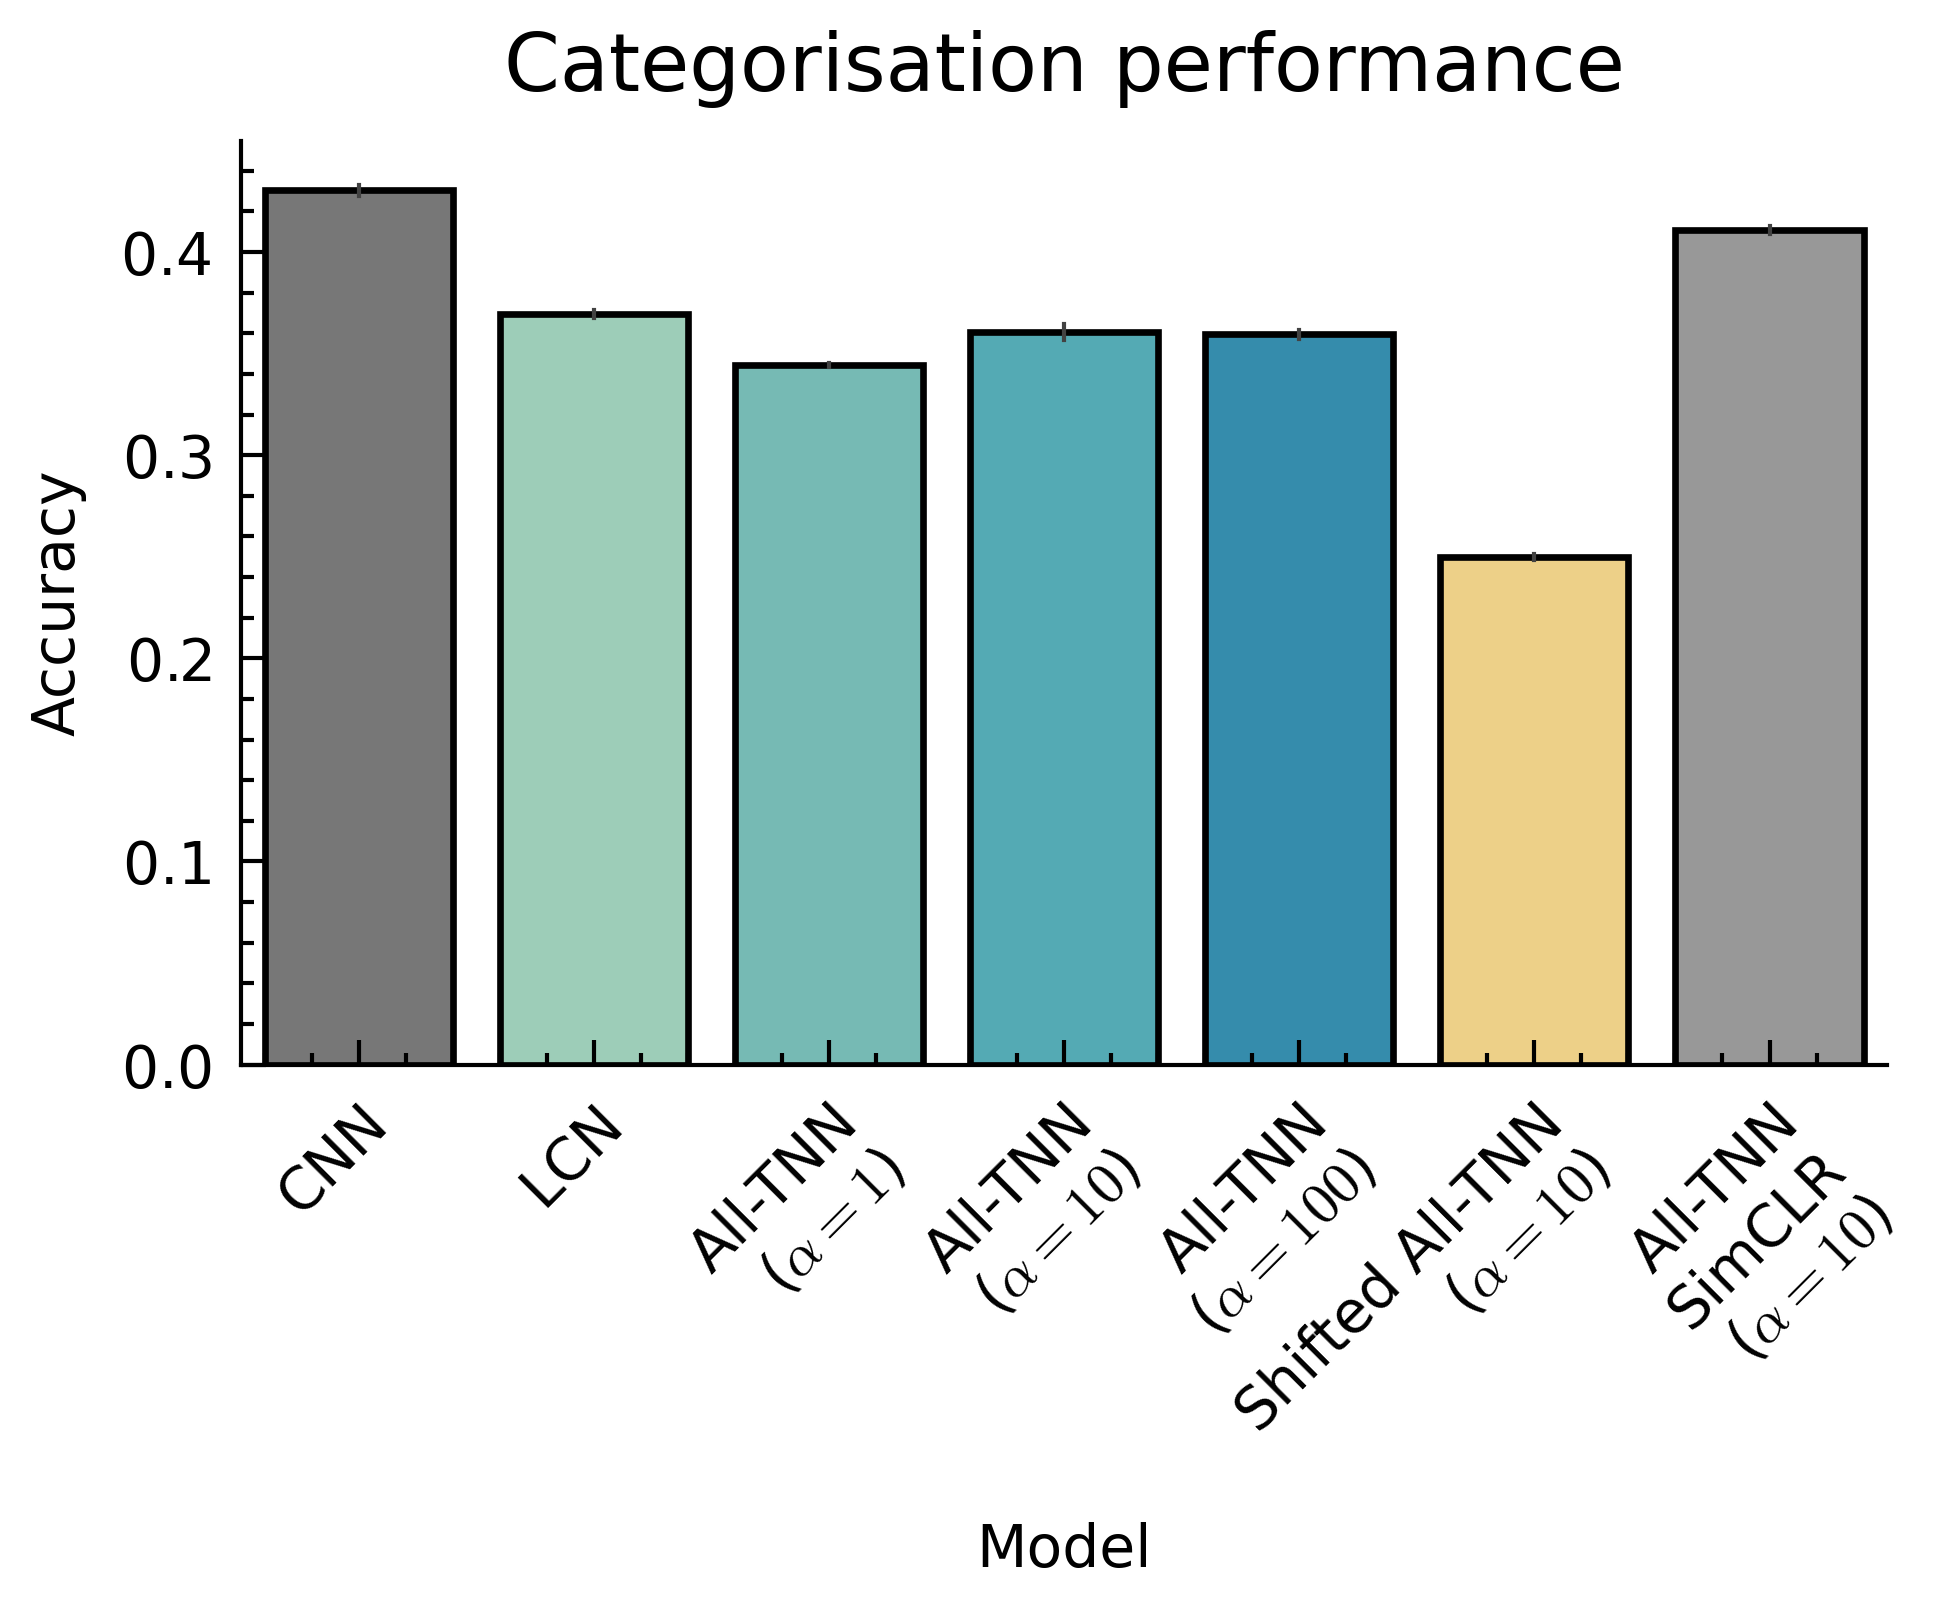

In [3]:
df = generate_analysis_df(
    base_src_dir_path=neural_level_h5_file_dir,
    MODEL_NAMES=config.MODEL_NAMES,
    seeds_range=config.SEEDS_RANGE,
    models_epochs_dict=config.MODELS_EPOCHS_DICT,
    MODEL_NAMES_TO_PLOT=config.MODEL_NAMES_TO_PLOT,
    model_results_dict_filename='all_multi_models_neural_dict.h5', # or default is multi_models_neural_dict.pickle
)
plot_bar_plot_from_df(df, plot_path_fig1+'accuracy_compare_across_alphas.pdf', 
                               x="Model", y="Accuracy", 
                               title = "Categorisation performance", 
                               color3_start_id = 1,
                               show_plot = True,
                               figsize=(3.54, 2))

### Spatial smoothness
Spatial smoothness is calculated as as 1/average cosine similarity between the weights of neighbouring units for all models.

/share/klab/vkapoor/python_workspace/All-TNN/all_tnn/analysis/visualization/acc_maps_visualization.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(palette=COLOR_THEME_WITH_ALPHA_SWEEP[color3_start_id:], *args, **kwargs)
/share/klab/vkapoor/python_workspace/All-TNN/all_tnn/analysis/visualization/acc_maps_visualization.py:64: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.barplot(palette=COLOR_THEME_WITH_ALPHA_SWEEP[color3_start_id:], *args, **kwargs)


Saved plot to /share/klab/datasets/TNN_paper_save_dir/All-TNN_share/plots/figure1mean_cosdist_compare_across_alphas.pdf


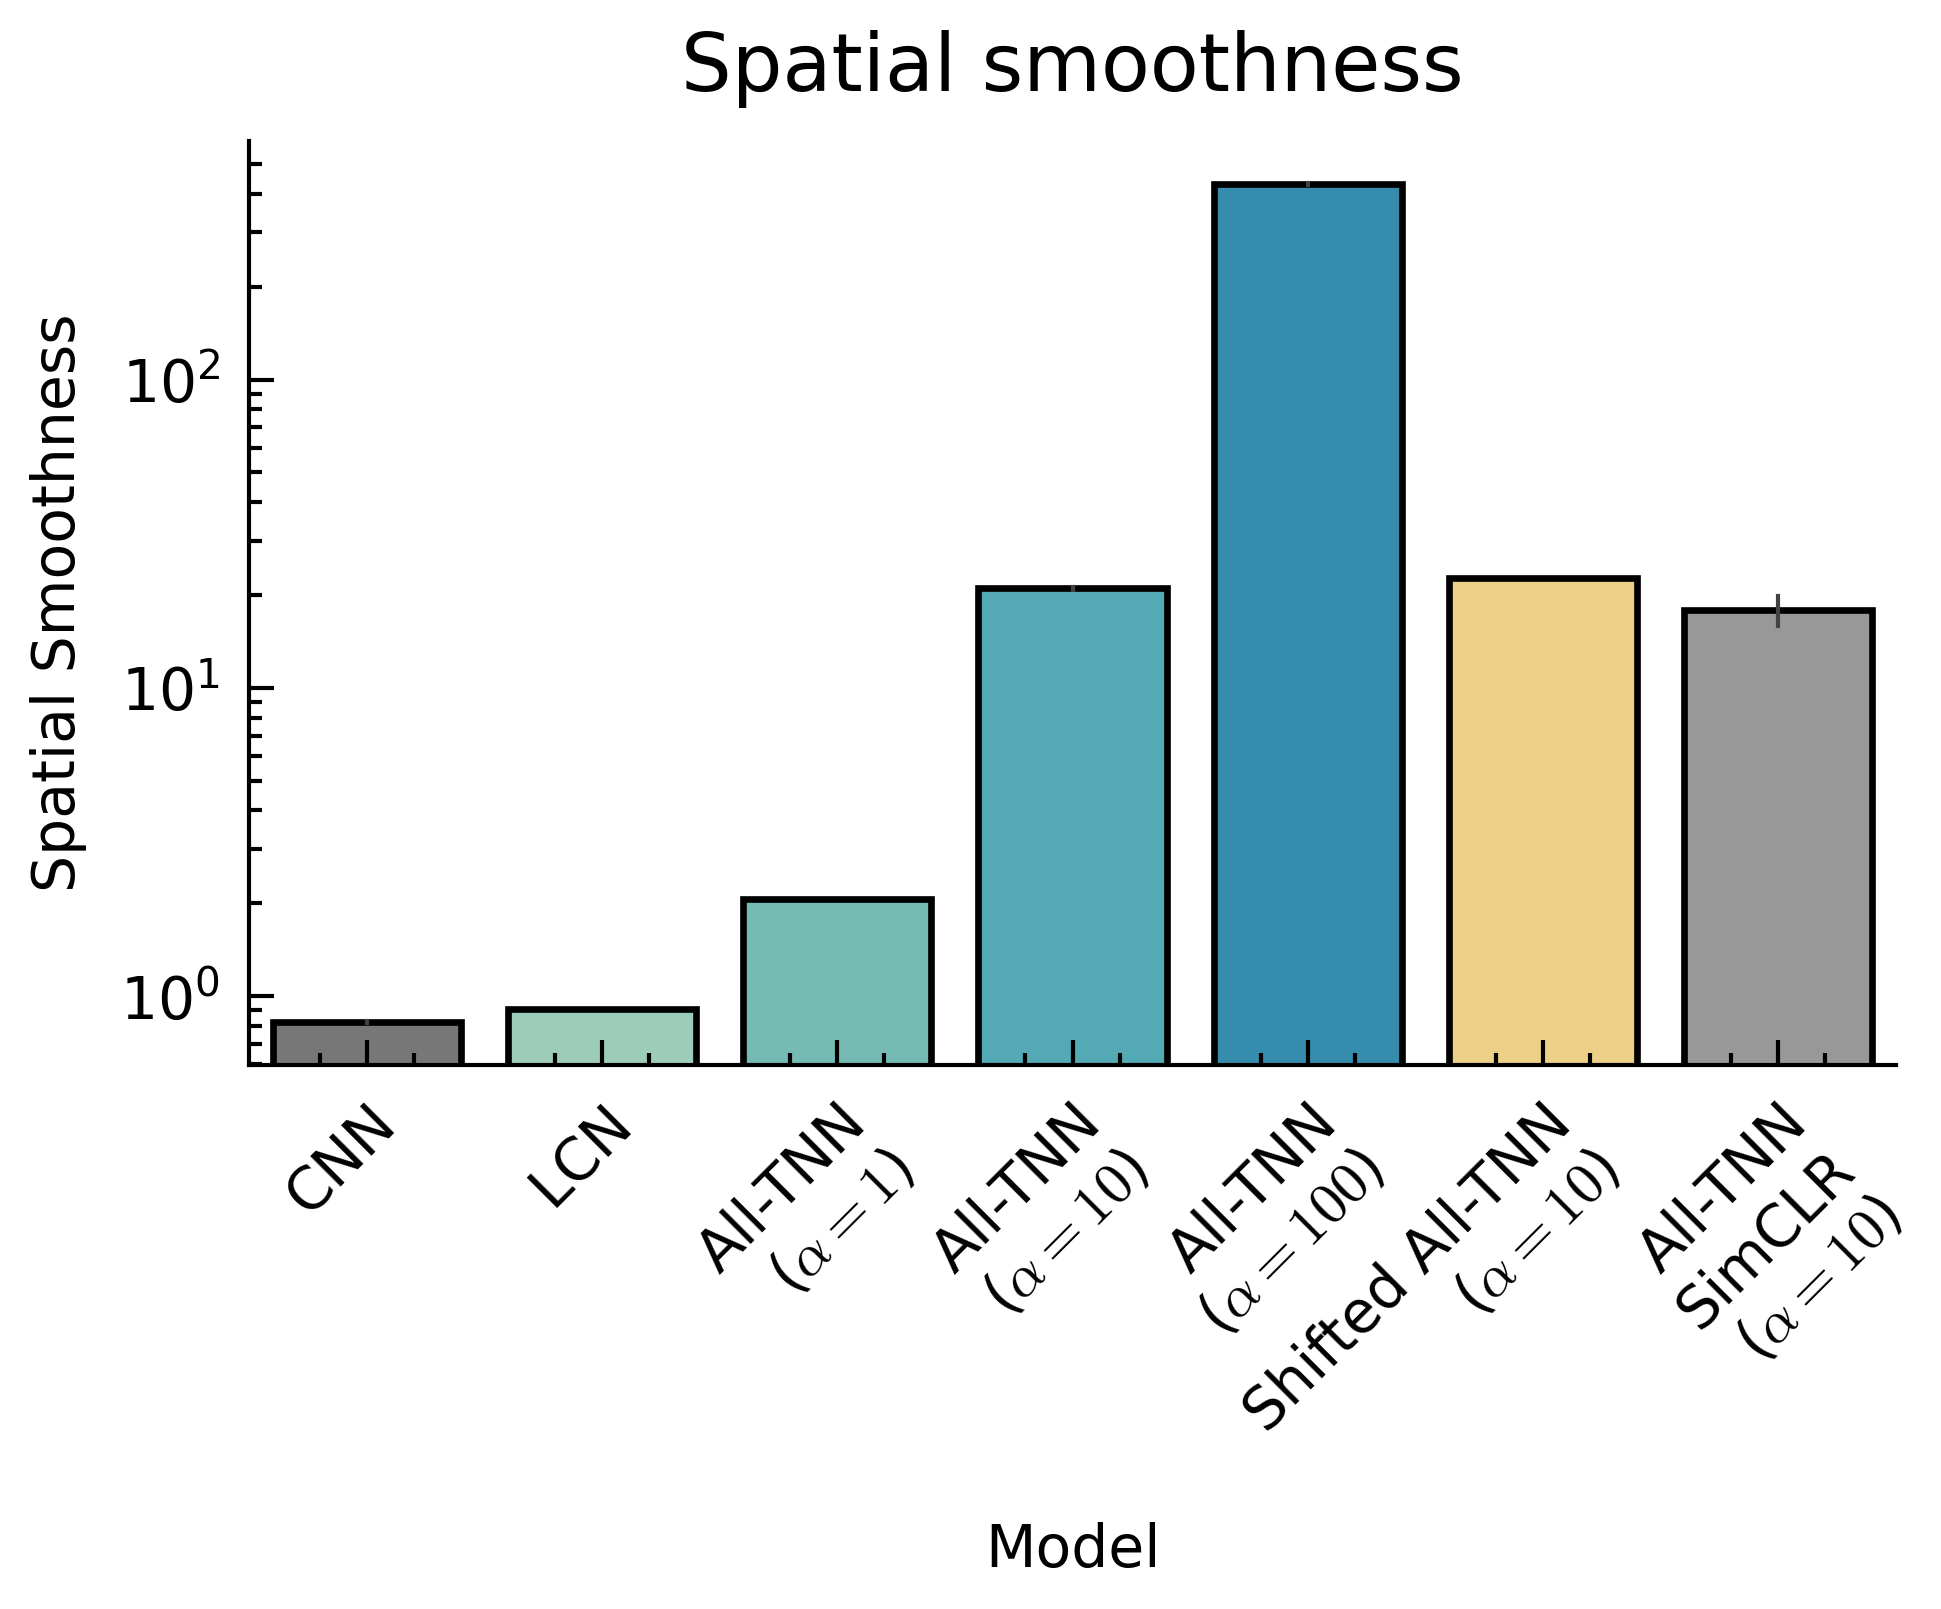

In [4]:
plot_bar_plot_from_df(df, plot_path_fig1+'mean_cosdist_compare_across_alphas.pdf',
                                    x="Model", y="Spatial Smoothness", 
                                    title = "Spatial smoothness", 
                                    color3_start_id = 1,
                                    show_plot = True,
                                    log_scale = True, #! log scale
                                    figsize=(3.54, 2))

## Figure 2
### Orientation selectivity maps, entropy of first layer orientation selectivity, and category selectivity maps.

True dict_keys(['category_selectivities', 'ecoset_test_accuracy', 'ecoset_test_loss', 'ecoset_test_topk_accuracy', 'grating_w_activities', 'grating_w_entropies', 'grating_w_radial_entropies', 'mean_cosdist', 'smoothness_analysis'])
Getting category selectivity maps for layer 0


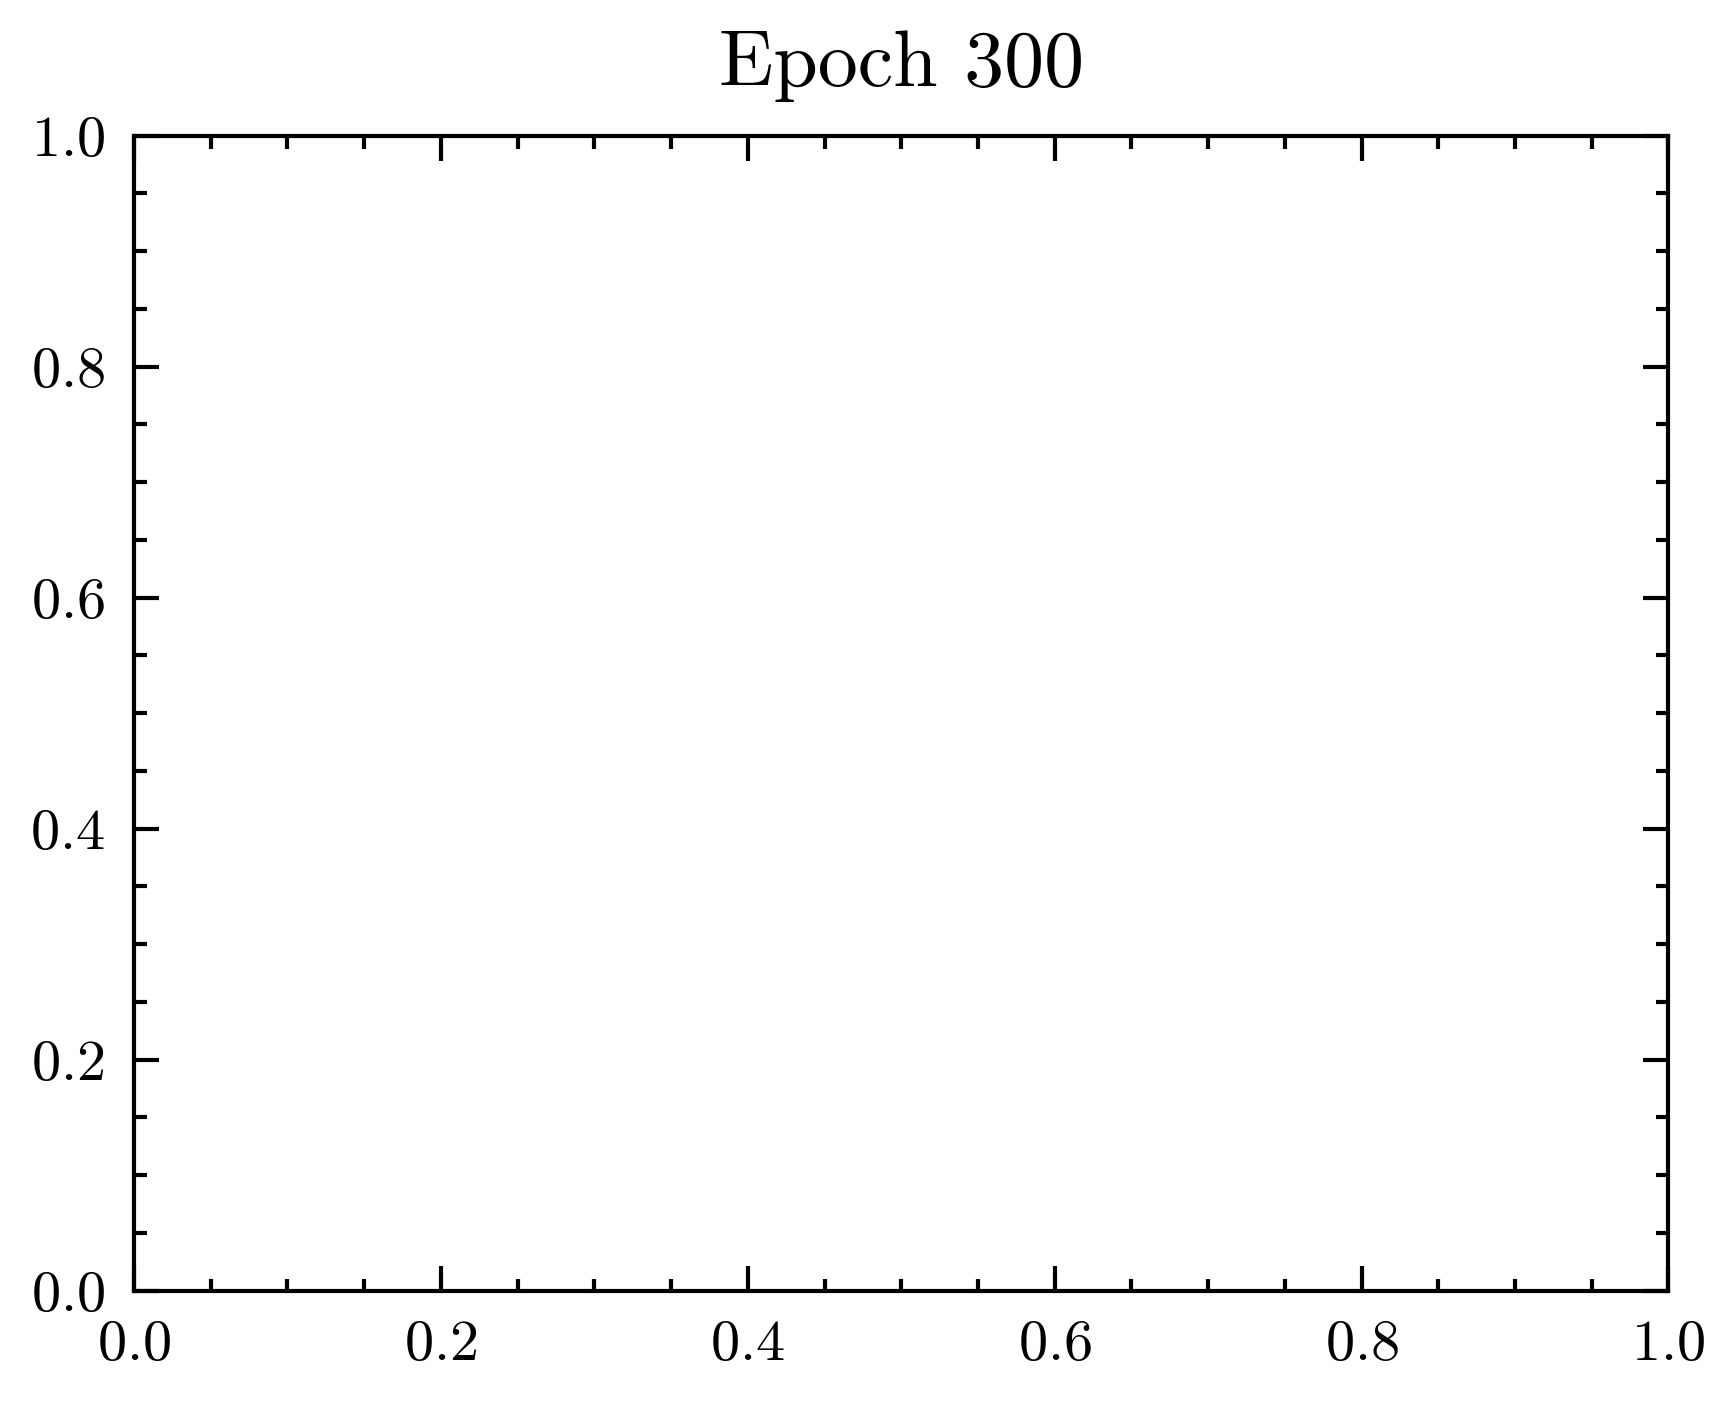

Saving dprime sheets for layer 0


In [5]:
seed = 1 # or pick another seed
model_name = "TNN_alpha_10" # or pick another model
seed_results = neural_level_h5_file_dir + f"/seed{seed}/all_multi_models_neural_dict.h5"
model_results_dict = read_h52dict(seed_results)
CATEGORY_STATS = 0
vis = visualize_layer(model_results_dict["TNN_alpha_10"], 300, layer_i=0, analysis_dir=plot_path_fig2, model_name=model_name, layer=None, save=True, show=True)

### Radial entropy profile

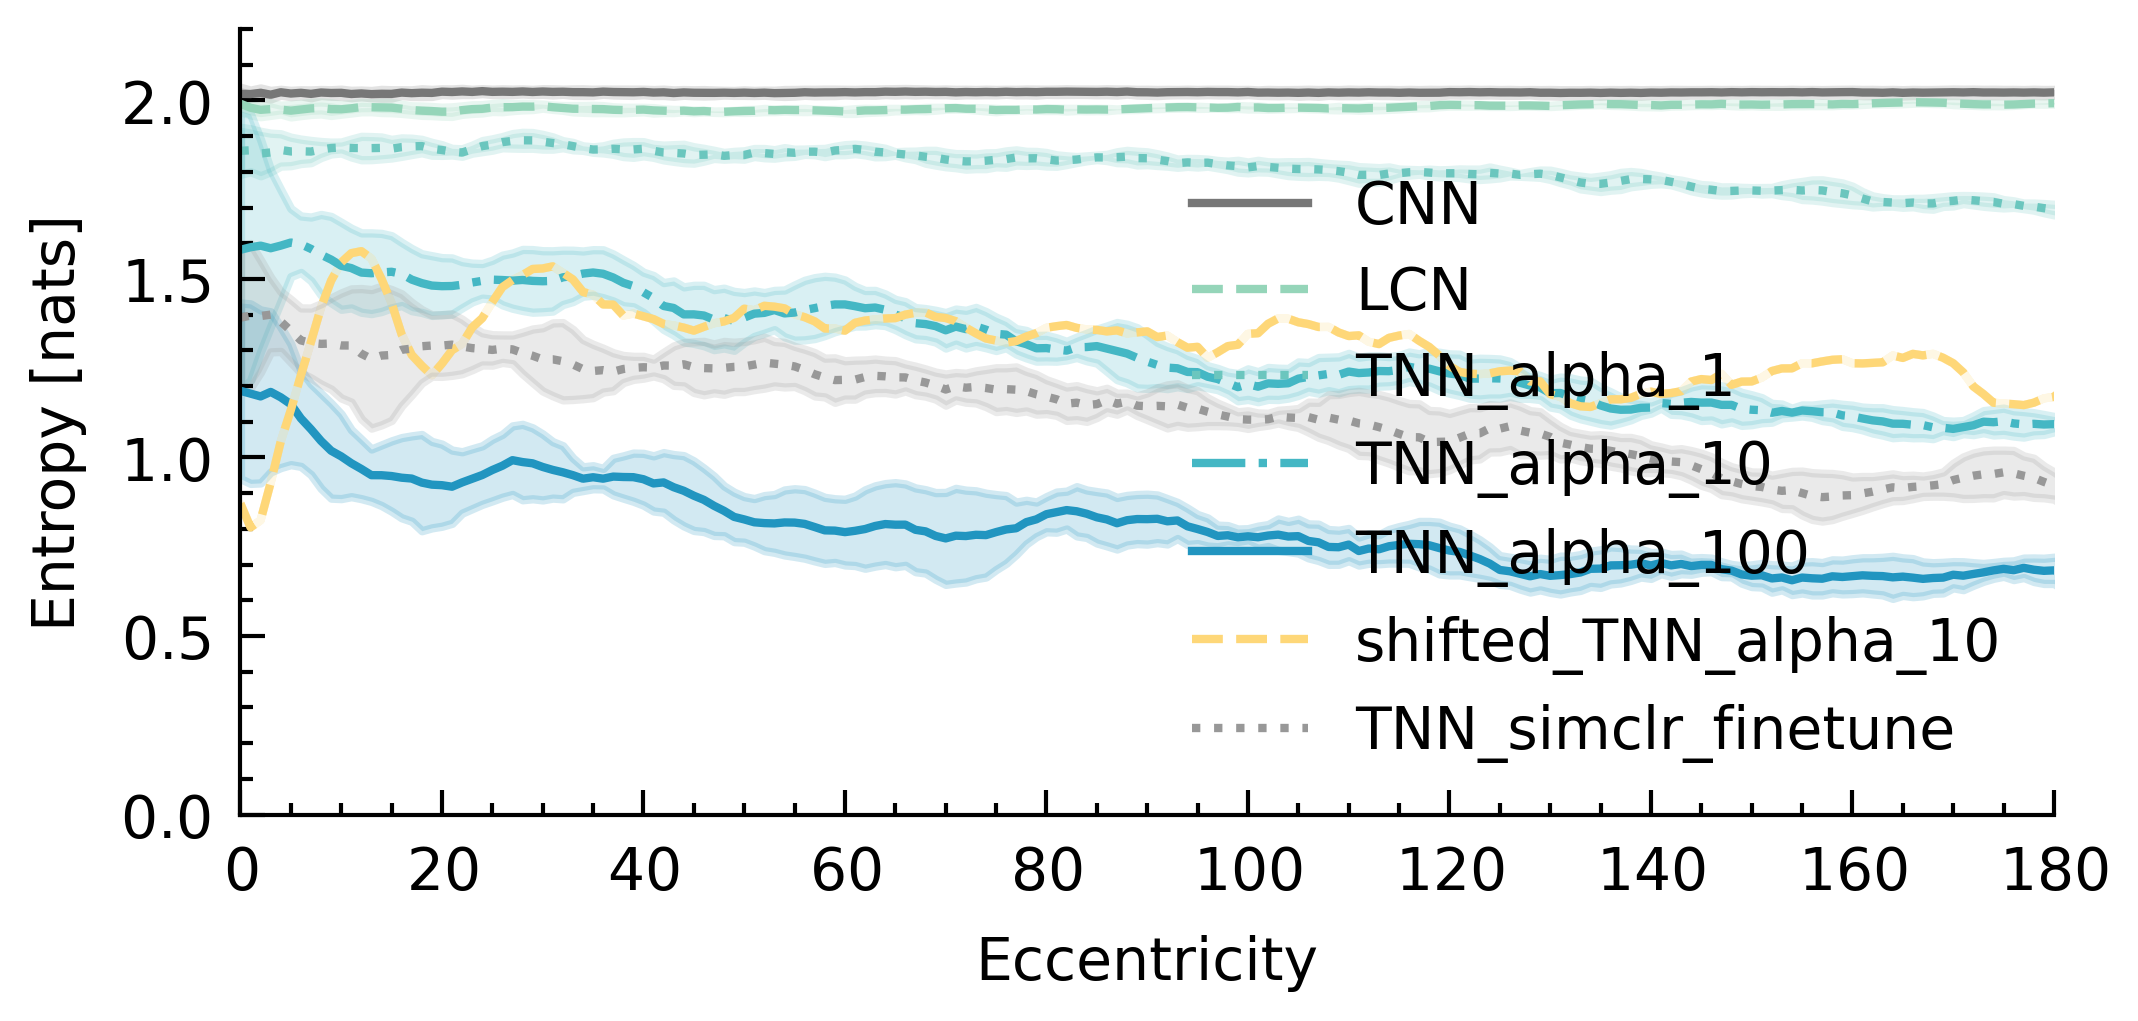

In [6]:
all_data = []
for seed in config.SEEDS_RANGE: 
    h5_file_path = neural_level_h5_file_dir + f"/seed{seed}/all_multi_models_neural_dict.h5"
    model_results_dict = read_h52dict(h5_file_path)
    all_data.append(model_results_dict)
    
ent_dict = calculate_radial_entropy(all_data, config.MODEL_NAMES)
plot_radial_entropy(ent_dict, color_palette, config.MODEL_NAMES, plot_path_fig2, save=True, show=True)

### Smoothness of orientation selectivity and category selectivity maps



/home/staff/v/vkapoor/.conda/envs/testenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/staff/v/vkapoor/.conda/envs/testenv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/staff/v/vkapoor/.conda/envs/testenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/staff/v/vkapoor/.conda/envs/testenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


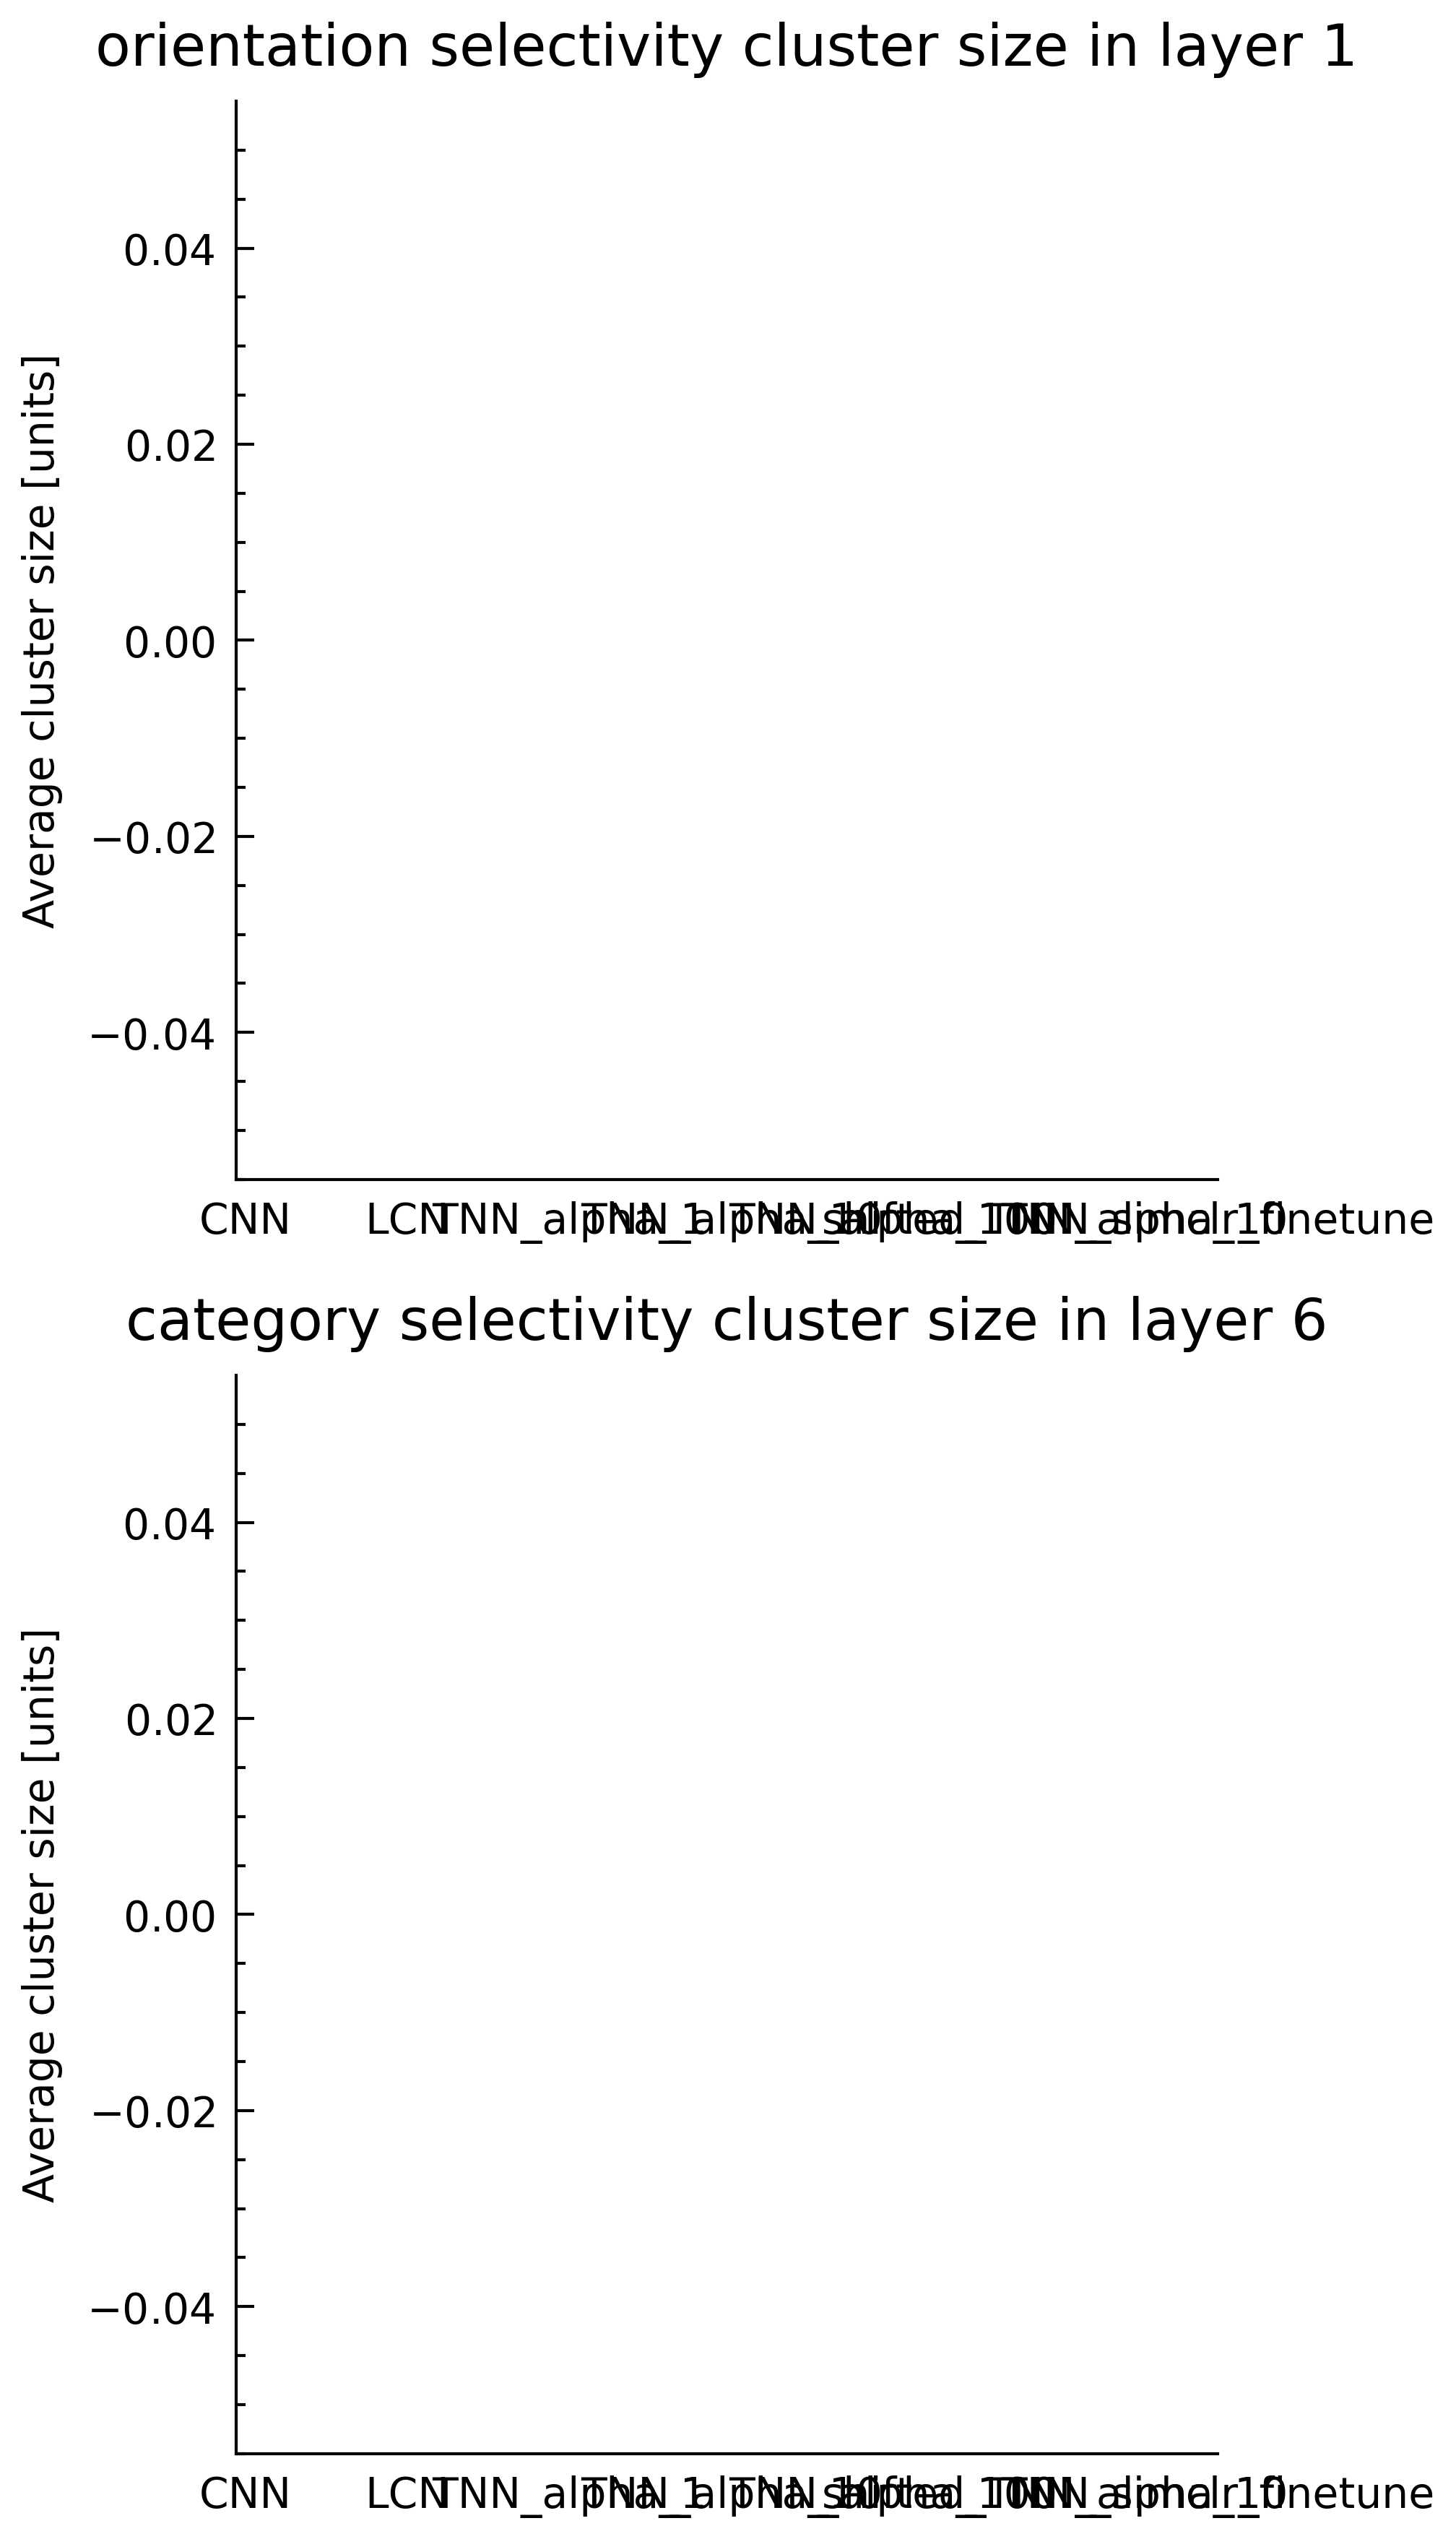

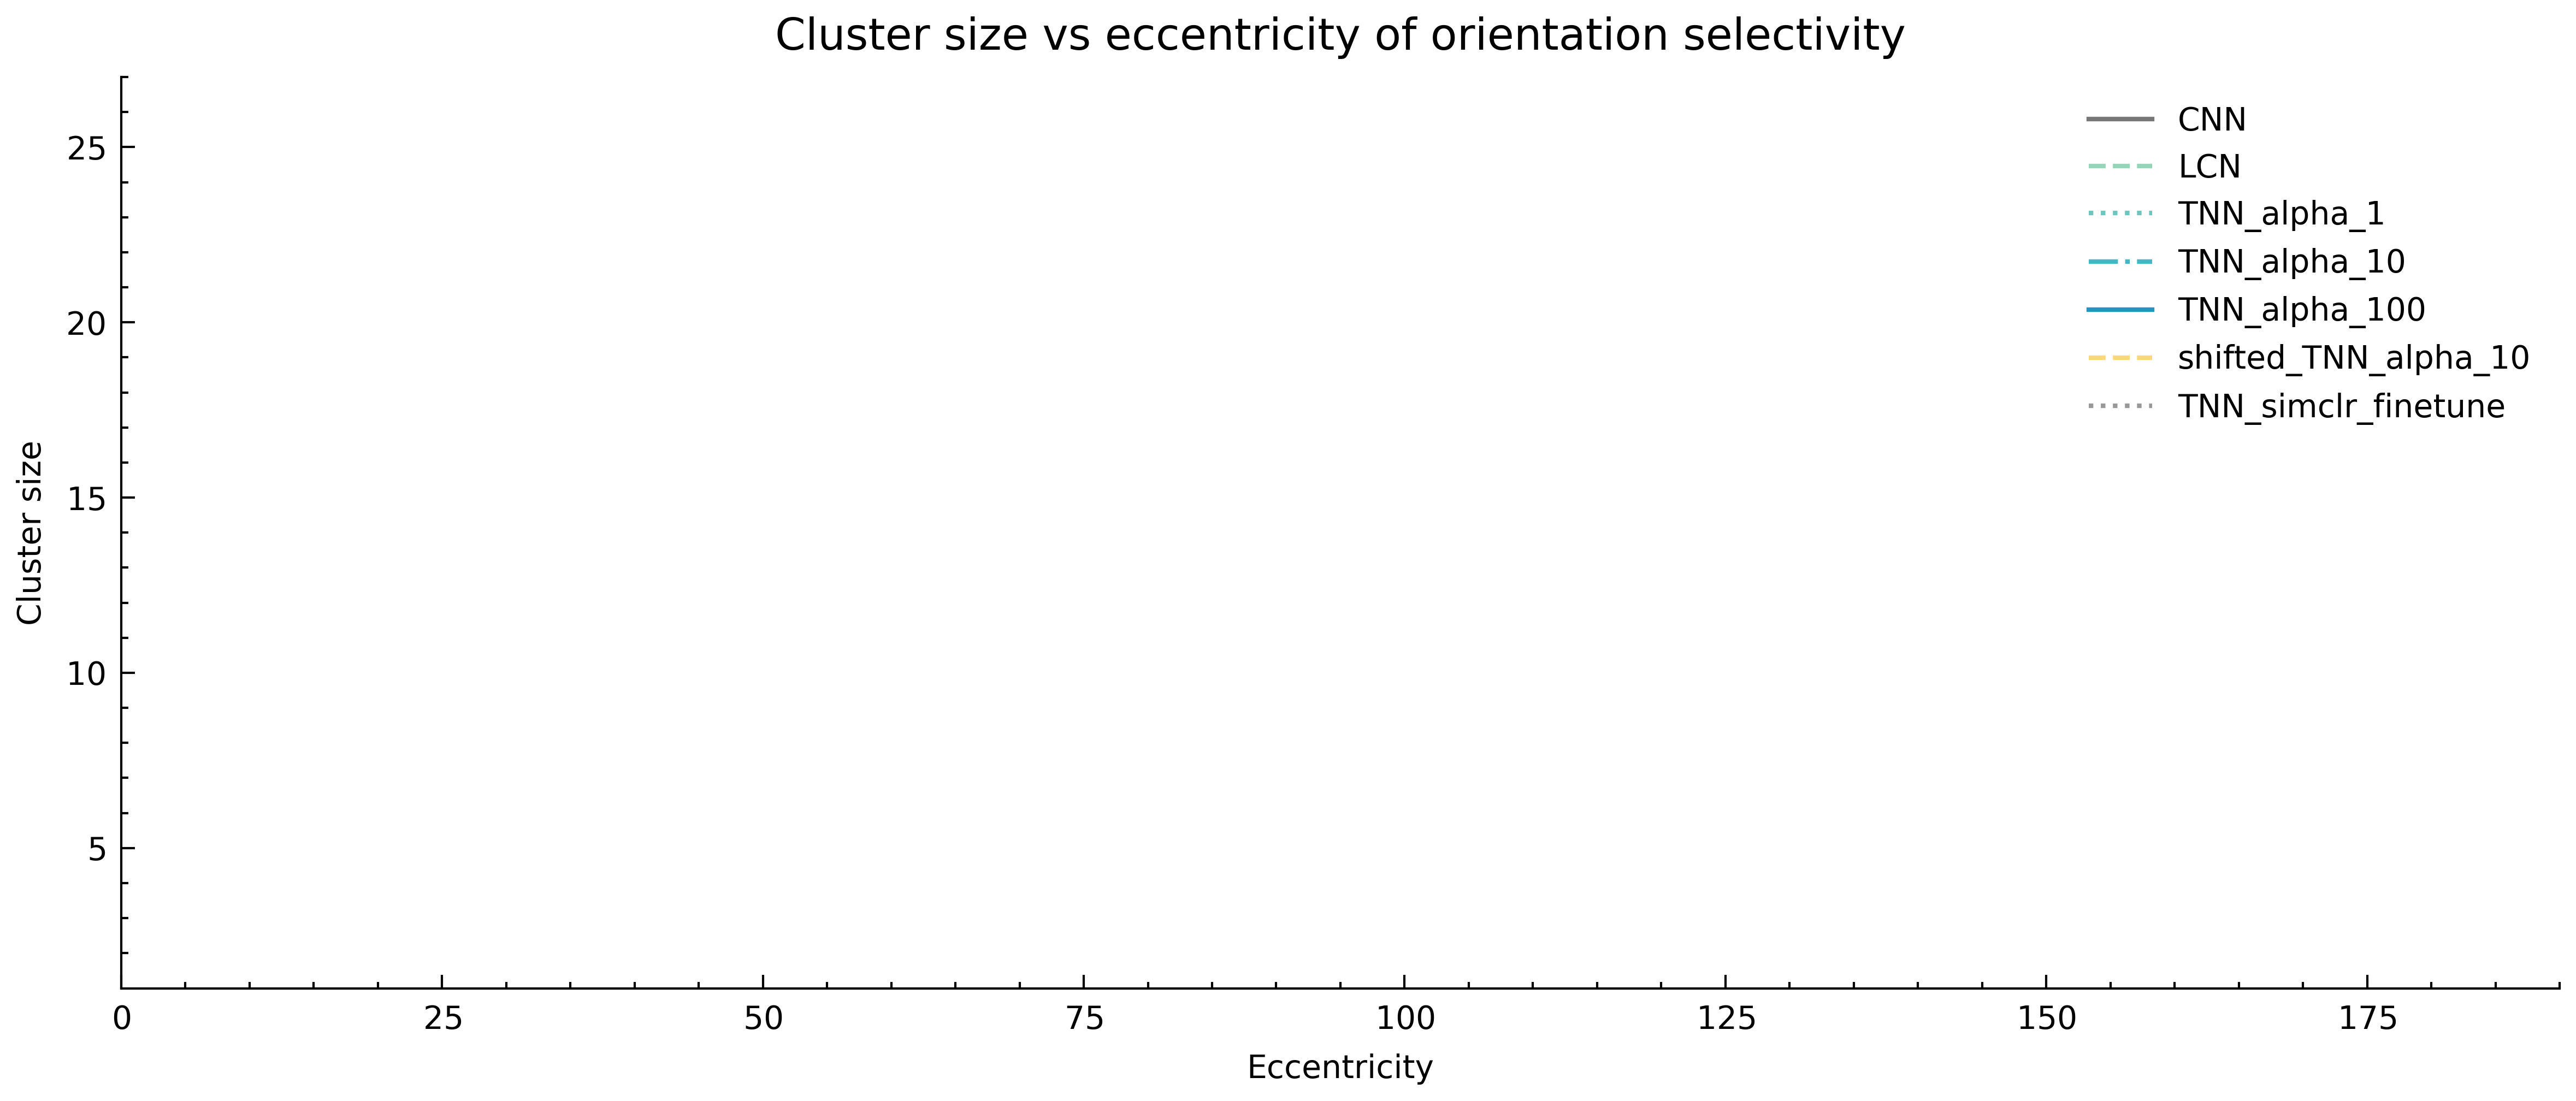

In [7]:
plot_cluster_size(all_data, color_palette, config.MODEL_NAMES, plot_path_fig2, stats=False, save=True, show=True)
cluster_size_vs_eccentricity(all_data, color_palette, config.MODEL_NAMES, plot_path_fig2, save=True, show=True)

## Figure 3
### Energy consumption
- For Figures 3A & 3B & 3C, simply run the following code. 

In [8]:
epochs_to_plot = [35] + list(range(50,601,50))
plot_energy_consumption_across_epochs_lineplot(
        model_name_path_dict=config.MODEL_NAME_PATH_DICT,
        alphas=config.ALPHAS,
        seed_range=config.SEEDS_RANGE,
        fixed_epochs=epochs_to_plot,
        save_fig_path=plot_path_fig3,
        pre_or_postrelu='postrelu',
        NORM_PREV_LAYER=True,
        NORM_LAYER_OUT=True,
    )

  0%|          | 0/7 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/share/klab/datasets/TNN_paper_save_dir/All-TNN_share/shared_weights/tnn_conv_control_ecoset_l2_no_flip_seed1_drop0.0_learnable_False_1e-05_alpha0.0_constant_20_0.1Factors_adam0.05_L21e-06_ecoset_square256_chunked/analysis_postrelu/energy_efficiency/ep35/ali_way_overall_sum_energy_consumption_layer1_NORM_LAYER_OUT_True_NORM_PREV_LAYER_True.npy'

In [9]:
plot_stacked_energy_map_energy_vs_eccentricity(
        model_name_path_dict=config.MODEL_NAME_PATH_DICT,
        alphas=config.ALPHAS,
        save_fig_path=plot_path_fig3,
        pre_or_postrelu='postrelu',
        prefix_list=[ 'ali_'],
        energy_consumption_types= ['total'],
        seed_range=config.SEEDS_RANGE,
        models_epochs_dict=config.MODELS_EPOCHS_DICT,
        NORM_PREV_LAYER=True,
        NORM_LAYER_OUT=False,
    )

FileNotFoundError: [Errno 2] No such file or directory: '/share/klab/datasets/TNN_paper_save_dir/All-TNN_share/shared_weights/tnn_conv_control_ecoset_l2_no_flip_seed1_drop0.0_learnable_False_1e-05_alpha0.0_constant_20_0.1Factors_adam0.05_L21e-06_ecoset_square256_chunked/analysis_postrelu/energy_efficiency/ep35/ali_5layers_NORM_LAYER_OUT_False_NORM_PREV_LAYER_True_CNN_alpha0.0_drop0.0_pre_relu_False_stacked_total_energy_map.npy'

In [10]:
plot_stacked_energy_maps_normalized(
        model_name_path_dict=config.MODEL_NAME_PATH_DICT,
        alphas=config.ALPHAS,
        save_fig_path=plot_path_fig3,
        pre_or_postrelu='postrelu',
        prefix_list=[ 'ali_'],
        energy_consumption_types= ['total'],
        seed_range= [1], 
        models_epochs_dict=config.MODELS_EPOCHS_DICT,
        NORM_PREV_LAYER=True,
        NORM_LAYER_OUT=False,
    )

FileNotFoundError: [Errno 2] No such file or directory: '/share/klab/datasets/TNN_paper_save_dir/All-TNN_share/shared_weights/tnn_ecoset_l2_no_flip_seed1_drop0.0_learnable_False_1e-05_alpha0.0_constant_20_0.1Factors_adam0.05_L21e-06_ecoset_square256_proper_chunks/analysis_postrelu/energy_efficiency/ep35/ali_5layers_NORM_LAYER_OUT_False_NORM_PREV_LAYER_True_LCN_alpha0.0_drop0.0_pre_relu_False_stacked_total_energy_map.npy'

## Figure 4
### Human object-specific biases are predicted by animacy and real-world size. 
 Non-negative least squares GLM analysis on the averaged human ADM shows significant unique variance explained by animacy and real-world size. 

In [11]:
glm_results = run_full_GLM_analysis(
    base_path=behaviour_src_dir,
    data_filename='human_adm/adm_dict_pearsonr_spearmanr.h5',
    plot_path = plot_path_fig4,
    model_type='average_human_adm',
    predictor_names=['animate', 'size', 'spiky'],  # or a custom list of predictors (see make_predictors() function)
    num_permutations=1000,
    verbose=True,)

Creating and plotting predictors...
______ Unique variance (Group) ______


TypeError: Indexing elements must be in increasing order

### Spatial biases in human and model behaviour

In [12]:
df_behavior_agreements = pd.read_csv(os.path.join(behaviour_src_dir, 'behaviour_analysis_results', 'df_behavior_agreements.csv'))
plot_bar_plot_from_df(df_behavior_agreements,
                        plot_path_fig4+'behaviour_agreements.pdf',
                        x="Model", y='pearsonr', title="Behaviour Agreement Analysis",
                        show_plot=False, color3_start_id=1, hline=None,
                        figsize=(3.54, 2),)

/share/klab/vkapoor/python_workspace/All-TNN/all_tnn/analysis/visualization/acc_maps_visualization.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(palette=COLOR_THEME_WITH_ALPHA_SWEEP[color3_start_id:], *args, **kwargs)
/share/klab/vkapoor/python_workspace/All-TNN/all_tnn/analysis/visualization/acc_maps_visualization.py:64: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  sns.barplot(palette=COLOR_THEME_WITH_ALPHA_SWEEP[color3_start_id:], *args, **kwargs)


Saved plot to /share/klab/datasets/TNN_paper_save_dir/All-TNN_share/plots/figure4behaviour_agreements.pdf


### Agreement with object-specific biases in human behaviour

In [13]:
df_adm_agreement = pd.read_csv(os.path.join(behaviour_src_dir, 'behaviour_analysis_results', 'df_adm_agreement.csv'))
plot_bar_plot_from_df(df_adm_agreement,
                        plot_path_fig4+'adm_agreements.pdf',
                        x="Model", y='spearmanr', title="ADM Agreement Analysis",
                        show_plot=False, color3_start_id=1, hline=None,
                        figsize=(3.54, 2),)

/share/klab/vkapoor/python_workspace/All-TNN/all_tnn/analysis/visualization/acc_maps_visualization.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(palette=COLOR_THEME_WITH_ALPHA_SWEEP[color3_start_id:], *args, **kwargs)
/share/klab/vkapoor/python_workspace/All-TNN/all_tnn/analysis/visualization/acc_maps_visualization.py:64: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  sns.barplot(palette=COLOR_THEME_WITH_ALPHA_SWEEP[color3_start_id:], *args, **kwargs)


Saved plot to /share/klab/datasets/TNN_paper_save_dir/All-TNN_share/plots/figure4adm_agreements.pdf


## Figure 5

- Figure 5 is produced by re-running the code for Figures 1–4 for the self-supervised (SimCLR) All-TNN ($\alpha = 10$) and the supervised All-TNN ($\alpha = 10$).

Change ``analysis/config.py`` (l. 27) by commenting out all other models: